# Brax: a differentiable physics engine

[Brax](https://github.com/google/brax) simulates physical systems made up of rigid bodies, joints, and actutators.  Brax provides the function:

$$
\text{state}_{t+1} = \text{step}(\text{system}, \text{state}_t, \text{act})
$$

where:
* $\text{system}$ is the static description of the physical system: each body in the world, its weight and size, and so on
* $\text{state}_t$ is the dynamic state of the system at time $t$: each body's position, rotation, velocity, and angular velocity
* $\text{act}$ is dynamic input to the system in the form of motor actuation

Brax simulations are differentiable: the gradient $\Delta \text{step}$ can be used for efficient trajectory optimization.  But Brax is also well-suited to derivative-free optimization methods such as evolutionary strategy or reinforcement learning.

Let's review how $\text{system}$, $\text{state}_t$, and $\text{act}$ are used:

In [1]:
#@title Colab setup and imports

import jax
from jax import numpy as jp
from matplotlib.lines import Line2D
from matplotlib.patches import Circle
import matplotlib.pyplot as plt

try:
  import brax
except ImportError:
  from IPython.display import clear_output 
  !pip install git+https://github.com/google/brax.git@main
  clear_output()
  import brax

## A bouncing ball

A Brax system is a [dataclass](https://flax.readthedocs.io/en/latest/api_reference/flax.struct.html) that may be constructed programmatically.  Brax also suports creating systems using [MJCF](https://mujoco.readthedocs.io/en/stable/XMLreference.html) and [URDF](http://wiki.ros.org/urdf/XML), two simple and intuitive physics scene xml formats.

Here we specify a ball with a radius of 0.5 meters, lying on the ground.  The time resolution of the simulation is 5 milliseconds.

In [2]:
from brax.io import mjcf

ball = mjcf.loads(
    """<mujoco>
         <option timestep="0.005"/>
         <worldbody>
           <body pos="0 0 3">
             <joint type="free"/>
             <geom size="0.5" type="sphere"/>
           </body>
           <geom size="40 40 40" type="plane"/>
         </worldbody>
       </mujoco>
  """)

Brax systems have all kinds of interesting fields we may manipulate or differentiate against.  For example, the mass of our sphere follows the formula $\frac{4}{3}\pi r^3\rho$ where $\rho$ is a default density of 1000 $\text{kg}/\text{m}^3$:

In [3]:
print(ball.link.inertia.mass, 4/3 * jp.pi * 0.5**3 * 1000)

[523.59875] 523.5987755982989


We visualize our ball like so:

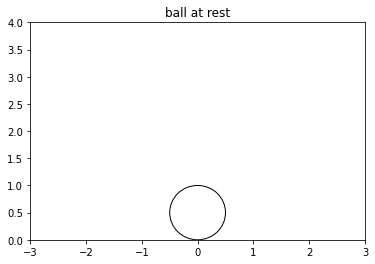

In [4]:
def visualize(ax, pos, alpha=1):
  for p, pn in zip(pos, list(pos[1:]) + [None]):
    ax.add_patch(Circle(xy=(p[0], p[2]), radius=0.5, fill=False, color=(0, 0, 0, alpha)))
    if pn is not None:
      ax.add_line(Line2D([p[0], pn[0]], [p[2], pn[2]], color=(1, 0, 0, alpha)))

_, ax = plt.subplots()
plt.xlim([-3, 3])
plt.ylim([0, 4])

visualize(ax, [[0, 0, 0.5]])
plt.title('ball at rest')
plt.show()

## Tossing the ball

To toss our ball, we:

* generate $\text{state}_0$ by calling `pipeline.init`
* generate each successive $\text{state}_{t+1}$ by calling `pipeline.step`

Try varying the ball's material elasticity in the system, or the ball's velocity in $\text{state}_0$:

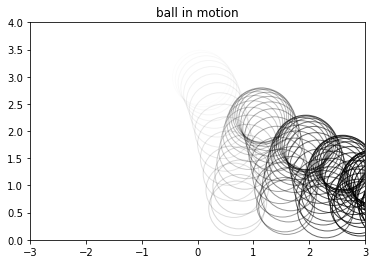

In [5]:
#@title { run: "auto"}
from brax.positional import pipeline

elasticity = 0.85 #@param { type:"slider", min: 0.5, max: 1.0, step:0.05 }
ball_velocity = 1 #@param { type:"slider", min:-5, max:5, step: 0.5 }

# change the material elasticity of the ball and the plane
ball = ball.replace(elasticity=jp.array([elasticity] * ball.ngeom))

# provide an initial velocity to the ball
qd = jp.array([ball_velocity, 0, 0, 0, 0, 0])
state = jax.jit(pipeline.init)(ball, ball.init_q, qd)

_, ax = plt.subplots()
plt.xlim([-3, 3])
plt.ylim([0, 4])

for i in range(1000):
  if i % 10 == 0:
    visualize(ax, state.x.pos, i / 1000.)
  state = jax.jit(pipeline.step)(ball, state, None)

plt.title('ball in motion')
plt.show()

# A triple pendulum

In Brax, links are bodies that are connected to one another by joints.  Let's make a triple pendulum, made of three links:

In [6]:
pendulum = mjcf.loads("""
<mujoco>
  <option timestep="0.01"/>
  <worldbody>
    <body pos="0 0 -0.5">
      <joint axis="0 1 0" type="hinge"/>
      <geom pos="0 0 -1.5" size=".1" type="sphere"/>
      <body pos="0 0 -1.5">
        <joint axis="0 1 0" type="hinge"/>
        <geom pos="0 0 -1.5" size=".1" type="sphere"/>
        <body pos="0 0 -1.5">
          <joint axis="0 1 0" type="hinge"/>
          <geom pos="0 0 -1.5" size=".1" type="sphere"/>
        </body>
      </body>
    </body>
  </worldbody>
</mujoco>
""")

state = pipeline.init(pendulum, pendulum.init_q, jp.zeros(pendulum.qd_size()))

Brax represents link positions and velocities using both [generalized](https://en.wikipedia.org/wiki/Generalized_coordinates) and maximal coordinates.

For generalized coordinates, we denote position as $\text{q}$ and velocity as $\text{qd}$.  For a triple pendulum, position is determined by a single joint angle per link.  Velocity is determined by a single joint velocity per link:

In [7]:
for q, qd in zip(state.q, state.qd):
  print(f'{q}\t{qd}')

0.0	0.0
0.0	0.0
0.0	0.0


For maximal coordinates we denote position as $\text{x}$ and velocity $\text{xd}$.  In maximal coordinates, every link uses 3 values for location in 3D space, and 4 values for orientation (a quaternion).  Velocity uses 3 values for linear velocity and 3 more for angular velocity:

In [8]:
for pos, rot, vel, ang in zip(state.x.pos, state.x.rot, state.xd.vel, state.xd.ang):
  print(f'{pos}   \t{rot}\t{vel}\t{ang}')

[ 0.   0.  -0.5]   	[1. 0. 0. 0.]	[0. 0. 0.]	[0. 0. 0.]
[ 0.  0. -2.]   	[1. 0. 0. 0.]	[0. 0. 0.]	[0. 0. 0.]
[ 0.   0.  -3.5]   	[1. 0. 0. 0.]	[0. 0. 0.]	[0. 0. 0.]


Here is our pendulum at rest:

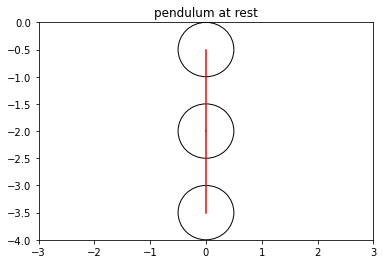

In [9]:
_, ax = plt.subplots()
plt.xlim([-3, 3])
plt.ylim([-4, 0])

visualize(ax, state.x.pos)
plt.title('pendulum at rest')
plt.show()

# Swinging the pendulum

Brax offers three distinct physics pipelines that are easy to swap:

* [Generalized](https://github.com/google/brax/blob/main/brax/v2/generalized/)
calculates motion in [generalized coordinates](https://en.wikipedia.org/wiki/Generalized_coordinates) using the same accurate robot
dynamics algorithms as [MuJoCo](https://mujoco.org/) and [TDS](https://github.com/erwincoumans/tiny-differentiable-simulator).
* [Positional](https://github.com/google/brax/blob/main/brax/v2/positional/)
uses [Position Based Dynamics](https://matthias-research.github.io/pages/publications/posBasedDyn.pdf),
a fast but stable method of resolving joint and collision constraints.
* [Spring](https://github.com/google/brax/blob/main/brax/v2/spring/) provides
fast and cheap simulation for rapid experimentation, using simple impulse-based
methods often found in video games.

Physics pipelines typically become less accurate and unstable as step size grows.  Try fiddling with step size to get a feel for each pipeline's accuracy and stability tradeoffs:

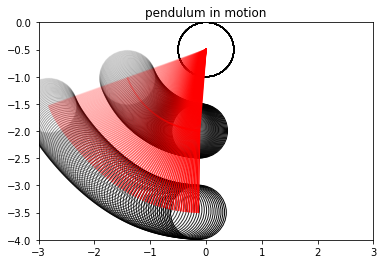

In [10]:
#@title { run: "auto"}

from brax.generalized import pipeline as generalized_pipeline 
from brax.positional import pipeline as positional_pipeline 
from brax.spring import pipeline as spring_pipeline 

initial_angle = 70 #@param { type:"slider", min:0, max:90, step: 1 }
pipeline = 'generalized'  #@param ["generalized", "positional", "spring"]
step_size = "1 ms" #@param [".4 ms", "1 ms", "5 ms"]

substeps = {'.4 ms': 25, '1 ms': 10, '5 ms': 2}[step_size]
stiffness = {'.4 ms': 20000, '1 ms': 10000, '5 ms': 500}[step_size]
pipeline = {'generalized': generalized_pipeline,
            'positional': positional_pipeline,
            'spring': spring_pipeline}[pipeline]

# find reasonable stiffness and damping for the given dt
link = pendulum.link.replace(
    constraint_stiffness=jp.repeat(stiffness, 3),
    constraint_vel_damping=jp.zeros((3,)))
pendulum = pendulum.replace(link=link)
pendulum = pendulum.tree_replace({'opt.timestep': 0.01 / substeps})

init_q = jp.array([initial_angle * jp.pi / 180, 0, 0])
state = jax.jit(pipeline.init)(pendulum, init_q, jp.zeros(pendulum.qd_size()))

_, ax = plt.subplots()
plt.xlim([-3, 3])
plt.ylim([-4, 0])

for i in range(100 * substeps):
  if i % substeps == 0:
    visualize(ax, state.x.pos, i / (100 * substeps))
  state = jax.jit(pipeline.step)(pendulum, state, None)

plt.title('pendulum in motion')
plt.show()

# Pointing the pendulum

Actuators apply forces to joints according to user input.  Users control actuator forces at each step via the $\text{act}$ parameter.

Let's add two position actuators to our system.  These allow us to control a desired target angle for their joints:

In [11]:
pointing_pendulum = mjcf.loads("""
<mujoco>
  <option timestep="0.01"/>
  <worldbody>
    <body pos="0 0 -0.5">
      <joint name="joint1" axis="0 1 0" type="hinge"/>
      <geom pos="0 0 -1.5" size=".1" type="sphere"/>
      <body pos="0 0 -1.5">
        <joint name="joint2" axis="0 1 0" type="hinge"/>
        <geom pos="0 0 -1.5" size=".1" type="sphere"/>
        <body pos="0 0 -1.5">
          <joint axis="0 1 0" type="hinge"/>
          <geom pos="0 0 -1.5" size=".1" type="sphere"/>
        </body>
      </body>
    </body>
  </worldbody>
  <actuator>
    <position joint="joint1" kp="250"/>
    <position joint="joint2" kp="250"/>
  </actuator>
</mujoco>
""")

Try changing the target angles of the two actuators.  Large enough target angles create some chaotic motion in the system:

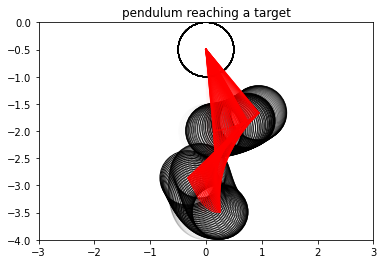

In [12]:
#@title { run: "auto"}

target_angle_0 = -30 #@param { type:"slider", min:-90, max:90, step: 1 }
target_angle_1 = 50 #@param { type:"slider", min:-90, max:90, step: 1 }

q = pointing_pendulum.init_q
qd = jp.zeros(pointing_pendulum.qd_size())
state = jax.jit(generalized_pipeline.init)(pointing_pendulum, q, qd)

_, ax = plt.subplots()
plt.xlim([-3, 3])
plt.ylim([-4, 0])

for i in range(100):
  visualize(ax, state.x.pos, i / 100)
  act = jp.array([target_angle_0, target_angle_1]) * jp.pi / 180
  state = jax.jit(generalized_pipeline.step)(pointing_pendulum, state, act)

plt.title('pendulum reaching a target')
plt.show()

Viszlát! 👋